In [1]:
!pip install -U pip
!pip install ipywidgets

/bin/bash: /home/tobi/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/tobi/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
!pip install -U matplotlib numpy shap

/bin/bash: /home/tobi/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached numpy-1.24.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
ERROR: Cannot uninstall numpy 1.24.3, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps numpy==1.24.3'.


In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import tensorflow as tf

from keras.applications.vgg16 import preprocess_input
from keras.models import load_model

2024-02-13 15:48:43.688115: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 15:48:43.724066: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 15:48:44.313832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Check if the GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load Data

In [5]:
X = np.load(os.path.join('..', 'Arrays', 'VGG16', 'x_train.npy'))
y = np.load(os.path.join('..', 'Arrays', 'VGG16', 'y_train.npy'))

X.shape, y.shape

((13576, 224, 224, 3), (13576, 9))

In [6]:
class_map = {
    0: 'credit_note',
    1: 'debit_note',
    2: 'order',
    3: 'proforma',
    4: 'purchase_order',
    5: 'receipt',
    6: 'sales_order',
    7: 'tax_invoice',
    8: 'utility_bill'
}

In [7]:
y_str = [class_map[np.argmax(row)] for row in y]
len(y_str)

13576

In [8]:
pd.Series(y_str).value_counts(ascending=False)

tax_invoice       5144
order             3925
purchase_order    2178
sales_order       1501
receipt            764
credit_note         26
proforma            24
utility_bill        10
debit_note           4
Name: count, dtype: int64

In [9]:
# Get test images
X_test_images = []
y_test_images = []

y_str_ser = pd.Series(y_str)

# Create a dictionary to store the first occurrence index of each class
first_occurrence_index = {}

# Iterate through the data to find the first occurrence index of each class
for idx, value in enumerate(y_str_ser):
    if value not in first_occurrence_index:
        first_occurrence_index[value] = idx

# Convert the dictionary to a pandas series
first_occurrence_index_series = pd.Series(first_occurrence_index)

print(first_occurrence_index_series)

tax_invoice          0
receipt              1
purchase_order       7
order                9
sales_order         22
debit_note         641
proforma           807
credit_note       1064
utility_bill      1874
dtype: int64


In [10]:
X_test_images = np.array([X[index] for index in first_occurrence_index_series.values])
y_test_images = np.array([label for label in first_occurrence_index_series.index])

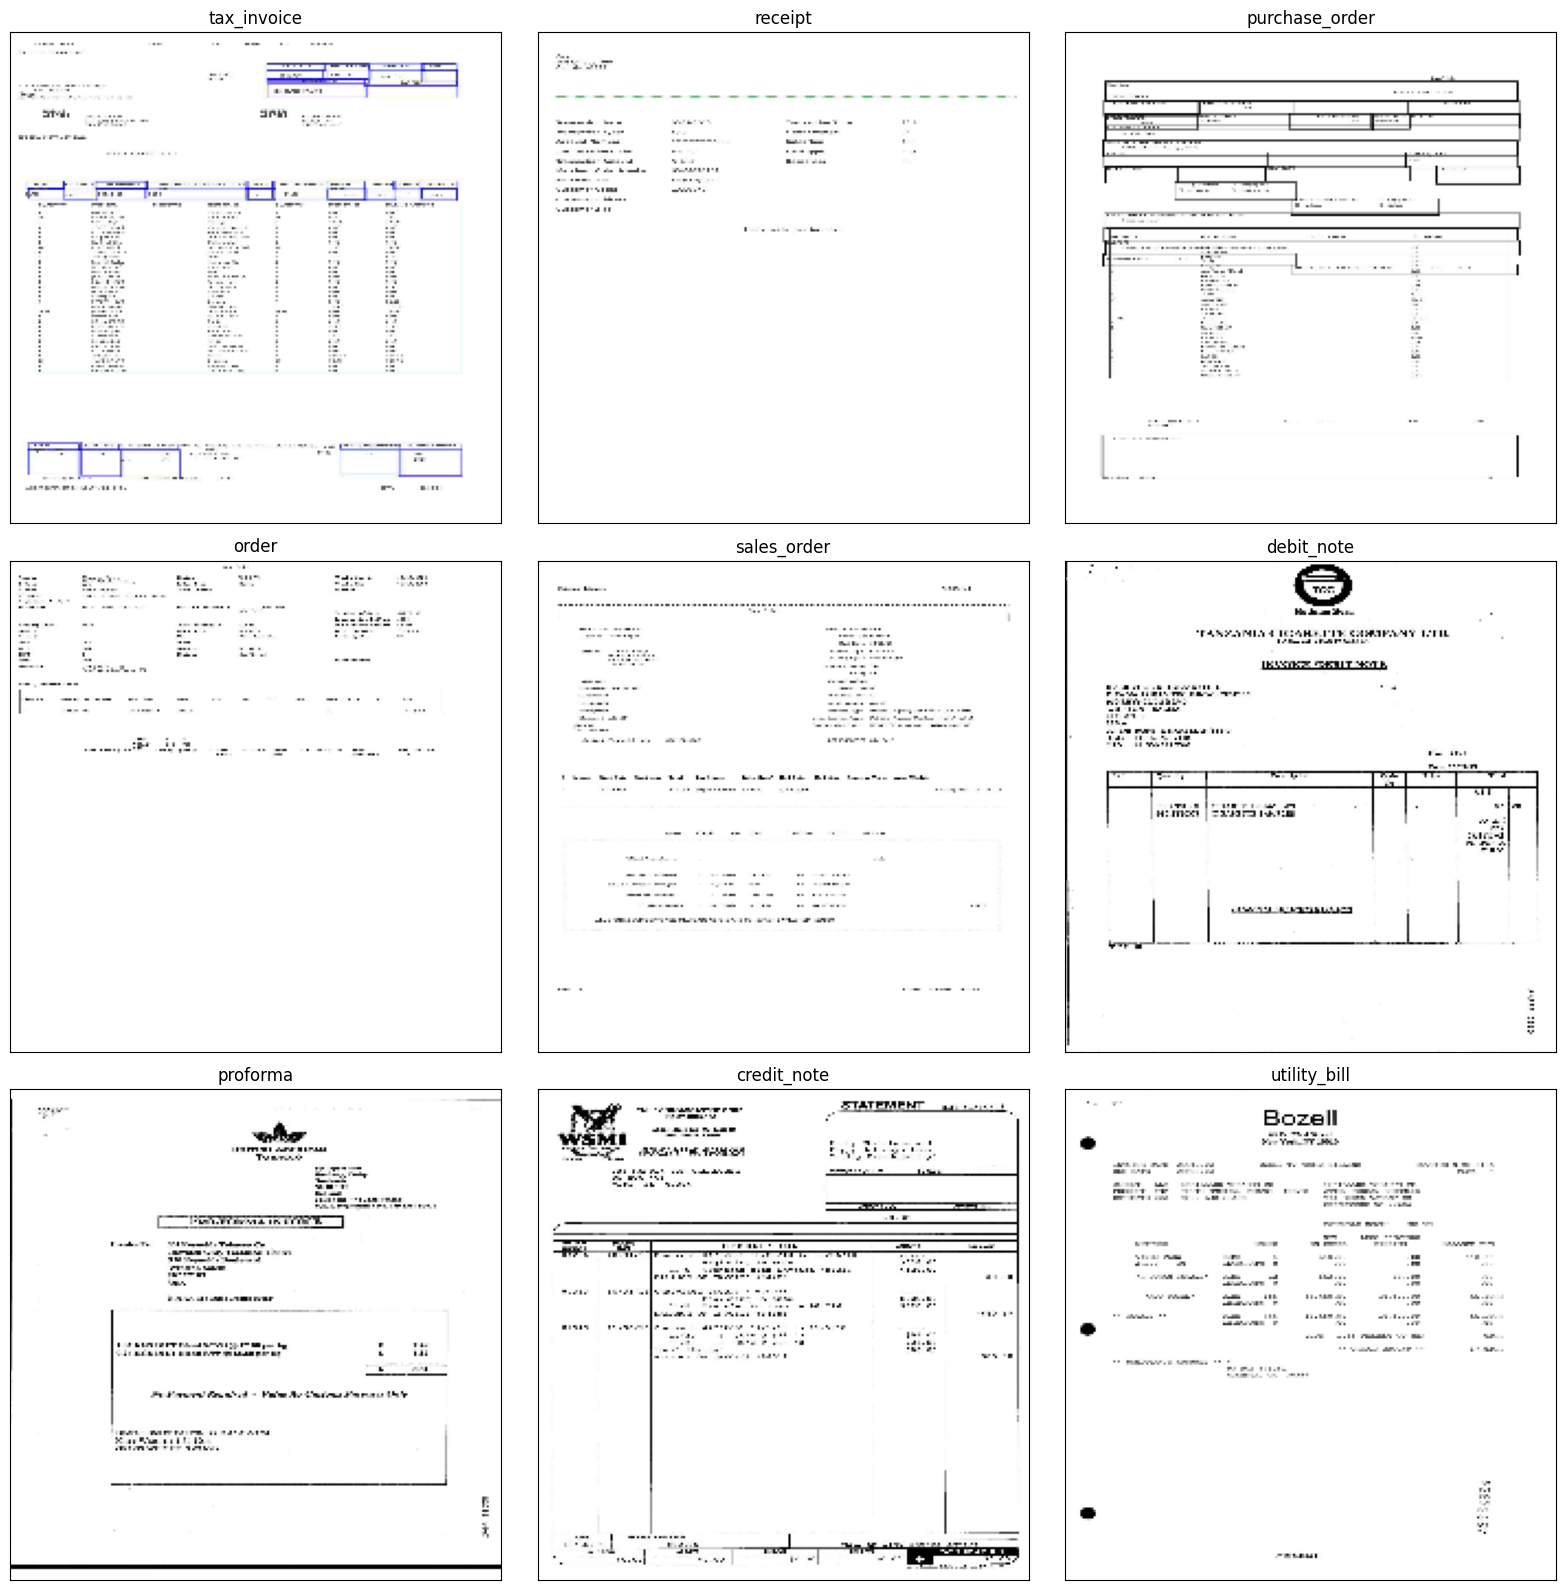

In [11]:
fig, axs = plt.subplots(3,3, figsize=(16, 16))

for i in range(0, 3):
    for j in range (0, 3):
        index = i * 3 + j
        test_image = X_test_images[index]
        label = y_test_images[index]
        
        ax = axs[i][j]
        ax.imshow(test_image)
        ax.set_title(label)
        ax.set_xticks([])
        ax.set_yticks([])
        
plt.tight_layout()
plt.show()

## Load Model

In [12]:
model = load_model(os.path.join('..', 'models', 'VGG16', 'trained_model_all_layer_100epochs_10_5.h5'))
model.summary()

2024-02-13 15:48:46.159604: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21079 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:68:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 9)                 1161      
                                                                 
Total params: 17927241 (68.39 MB)
Trainable params: 17927241 (68.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# select a set of background examples to take an expectation over
background = X[np.random.choice(X.shape[0], 25, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(X_test_images, check_additivity=False)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
2024-02-13 15:48:47.171433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-13 15:48:47.233990: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [18]:
y_test_images.tolist()

['tax_invoice',
 'receipt',
 'purchase_order',
 'order',
 'sales_order',
 'debit_note',
 'proforma',
 'credit_note',
 'utility_bill']

TypeError: 'Axes' object is not subscriptable

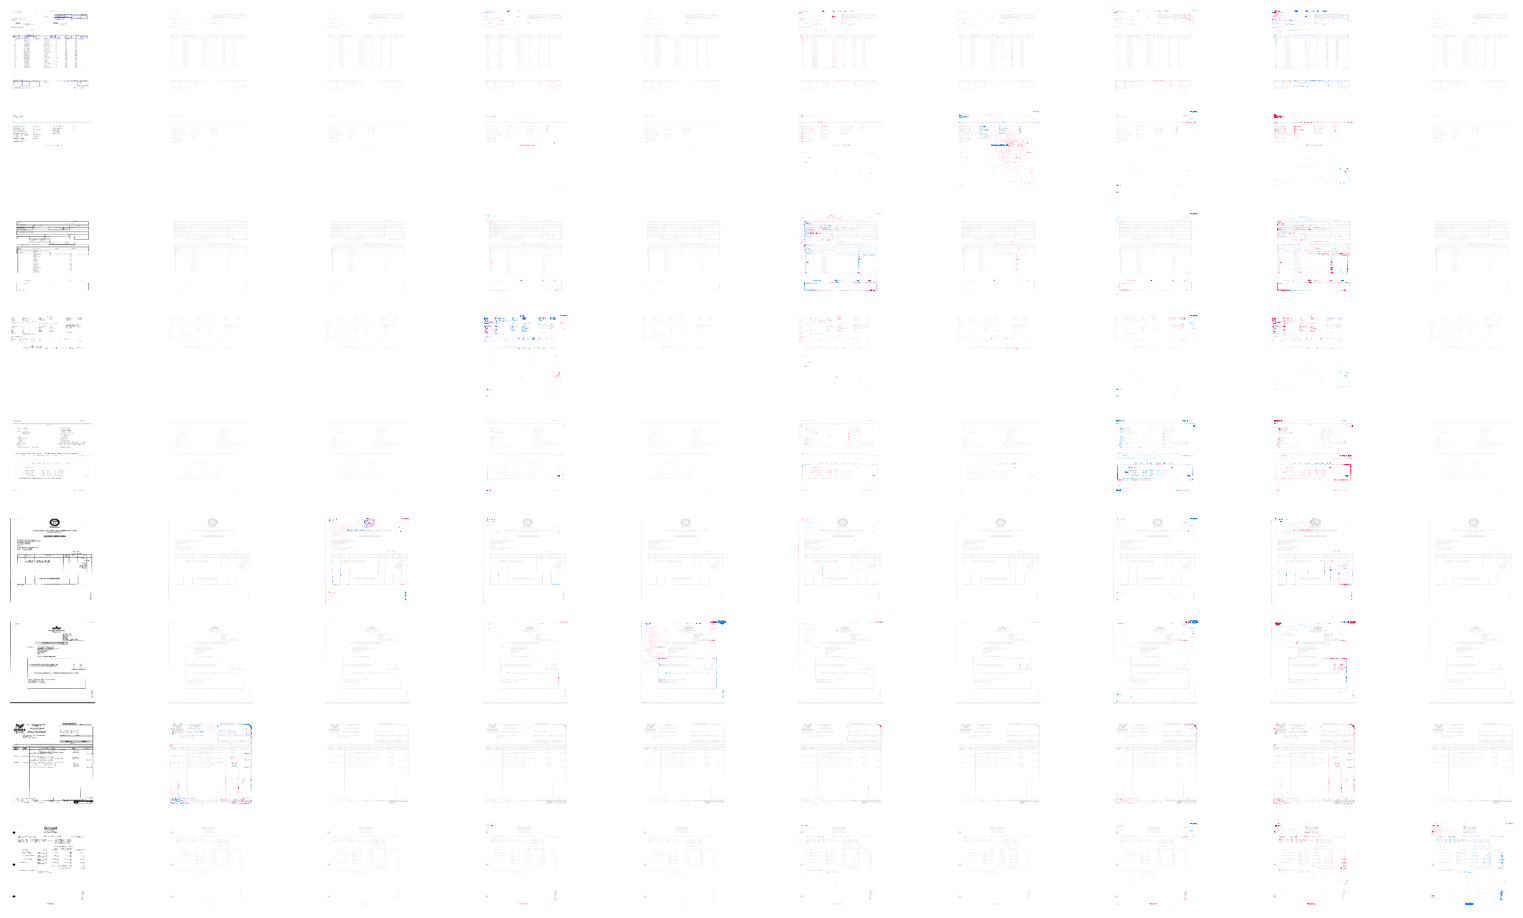

In [47]:
# plot the feature attributions
shap.image_plot(shap_values, X_test_images, show=False)
plt.gca().images[-1].colorbar.remove()
axs = plt.gcf().axes
for ax in axs[0][1:]:
    pass

plt.tight_layout()

In [ ]:
# TODO: nur richtig klassifizierte anschauen